## MOUNT Google Drive

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!lscpu |grep 'Model name'
!lscpu |grep 'Core(s) per socket:'
!free -h
!lscpu |grep 'Thread(s) per core'

Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz
Core(s) per socket:  4
              total        used        free      shared  buff/cache   available
Mem:            51G        4.6G         39G         13M        6.5G         47G
Swap:            0B          0B          0B
Thread(s) per core:  2


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Dec 19 16:22:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    36W / 250W |   3075MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## IMPORTS

In [ ]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR
import os, sys, time
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## CONSTANTS

In [ ]:
CHECKPOINT_PATH ="/content/drive/MyDrive/ml_epfl/ml_road_segmentation/checkpoint/current_checkpoint.pt"
BEST_MODEL_PATH ="/content/drive/MyDrive/ml_epfl/ml_road_segmentation/checkpoint/best_model.pt"

LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-6
GAMMA = 1
DIM_IMG_TRAIN = 400

## UNET model

In [ ]:
def double_conv(nbr_channels_in, nbr_channels_out):
    return nn.Sequential(
      nn.Conv2d(nbr_channels_in, nbr_channels_out, (3,3), padding=(1, 1)),
      nn.BatchNorm2d(nbr_channels_out),
      nn.ReLU(),
      nn.Conv2d(nbr_channels_out, nbr_channels_out, (3,3), padding=(1, 1)),
      nn.ReLU(),
      nn.BatchNorm2d(nbr_channels_out),
)


def one_step_up(x, x_d_i, pre_up_i, up_i):
    return up_i(torch.cat((pre_up_i(x), x_d_i), dim=1))


class u_net(nn.Module):
    def __init__(self):
        super(u_net, self).__init__()

        self.down_pooling = nn.MaxPool2d(2, 2)

        # Convolution Downwards
        self.down_1 = double_conv(3, 64) 
        self.down_2 = double_conv(64, 128)
        self.down_3 = double_conv(128, 256)
        self.down_4 = double_conv(256, 512)
        self.middle =  double_conv(512, 1024)
        
        # Upconvolution
        self.pre_up_1 = nn.ConvTranspose2d(1024, 512, (2, 2), (2, 2))
        self.up_1 = double_conv(512 + 512, 512)
                
        self.pre_up_2 = nn.ConvTranspose2d(512, 256, (2, 2), (2, 2))
        self.up_2 = double_conv(256 + 256, 256)
          
        self.pre_up_3 = nn.ConvTranspose2d(256, 128, (2, 2), (2, 2))
        self.up_3 = double_conv(128 + 128, 128)

        self.pre_up_4 = nn.ConvTranspose2d(128, 64, (2, 2), (2, 2))
        self.up_4 = double_conv(64 + 64, 64)

        self.final_convolution = nn.Conv2d(64, 2, (1,1))
        

    def forward(self, x):
        x_d_1 = self.down_1(x)
        x_d_2 = self.down_2(self.down_pooling(x_d_1))
        x_d_3 = self.down_3(self.down_pooling(x_d_2))
        x_d_4 = self.down_4(self.down_pooling(x_d_3))

        x = self.middle(self.down_pooling(x_d_4))

        x = one_step_up(x, x_d_4, self.pre_up_1, self.up_1)
        x = one_step_up(x, x_d_3, self.pre_up_2, self.up_2)
        x = one_step_up(x, x_d_2, self.pre_up_3, self.up_3)
        x = one_step_up(x, x_d_1, self.pre_up_4, self.up_4)
        
        return self.final_convolution(x)


## LOAD MODEL

In [ ]:
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model:           model that we want to load checkpoint parameters into       
    optimizer:       optimizer we defined in previous training
    
    Return model, optimizer, scheduler, epoch value, f1 score
    """
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # Get epoch number, f1_max, scheduler
    epoch = checkpoint['epoch']
    f1_max = checkpoint['f1_max']
    scheduler = checkpoint['scheduler']
    f1_validation = checkpoint['f1_validation']
    acc_validation = checkpoint['acc_validation']
    f1_training = checkpoint['scheduler']
    acc_training = checkpoint['acc_training']

    return model, optimizer, scheduler, epoch, f1_max, f1_validation, acc_validation, f1_training, acc_training

In [ ]:
#Prediction
LOAD_BEST_MODEL = True
LOAD_LAST_CHECKPOINT = not LOAD_BEST_MODEL
COLD_START = False

In [ ]:
# Declare UNET model, otimizer, adaptative learning rate and loss function
model =  u_net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = ExponentialLR(optimizer, GAMMA)
criterion = nn.CrossEntropyLoss()
f1_max = 0

if not COLD_START:
    if LOAD_LAST_CHECKPOINT and not LOAD_BEST_MODEL:
        model, optimizer, scheduler, epoch, f1_max, f1_validation, acc_validation, f1_training, acc_training = load_ckp(CHECKPOINT_PATH, model, optimizer)
    
    if not LOAD_LAST_CHECKPOINT and LOAD_BEST_MODEL:
        model.load_state_dict(torch.load(BEST_MODEL_PATH))

## PREDICTIONS

In [ ]:
# Utilities
to_tensor = T.ToTensor() 
toPIL = T.ToPILImage()

DIM_IMG_TEST = 608

In [ ]:
def load_test_dataset():
    root_test_dir = "/content/drive/MyDrive/ml_epfl/ml_road_segmentation/data/test_set_images/"
    test_i = 'test_'
    n = len(os.listdir(root_test_dir))
    test_imgs = [to_tensor(Image.open(root_test_dir + test_i + str(idx_img) +'/'+ test_i + str(idx_img) + '.png')).reshape((1, 3, DIM_IMG_TEST, DIM_IMG_TEST)) for idx_img in range(1, n+1)]
    return test_imgs
  
test_images = load_test_dataset()

In [ ]:
def make_predictions(model, test_images):
    model.eval()
    predicted_images = [torch.argmax(model(img.to(device)), dim = 1).cpu().float() for img in test_images]
    return predicted_images

predictions = make_predictions(model, test_images)

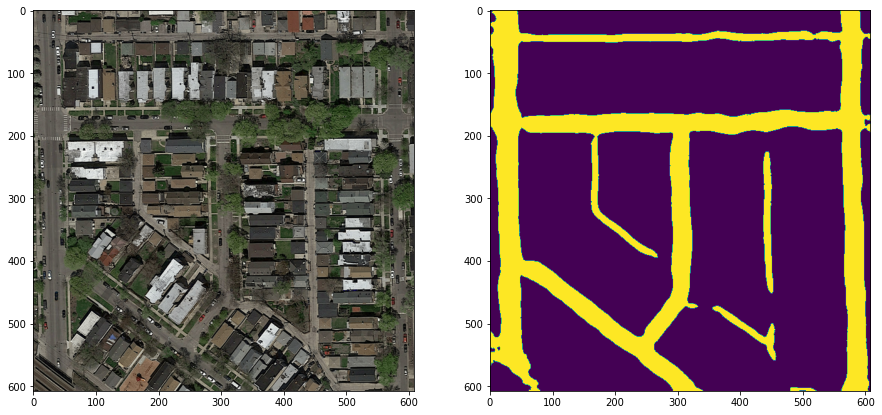

In [ ]:
plt.figure(figsize=(15,15))
IMG_INDEX = 9
images = [toPIL(test_images[IMG_INDEX].reshape((3, DIM_IMG_TEST, DIM_IMG_TEST))), toPIL(predictions[IMG_INDEX])]
for i, image in enumerate(images):
    plt.subplot(1, 2, i+1)
    plt.imshow(image)

In [ ]:
predictions_PIL = [toPIL(img) for img in predictions]

for idx_img in range(1, len(predictions_PIL)+1):
    predictions_PIL[idx_img-1].save("/content/drive/MyDrive/ml_epfl/ml_road_segmentation/data/predicted_test_set_images/test_" + '%.3d' % idx_img + ".png")

In [ ]:
import os
import numpy as np
import matplotlib.image as mpimg
import re

foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

# assign a label to a patch
def patch_to_label(patch):
    df = np.mean(patch)
    if df > foreground_threshold:
        return 1
    else:
        return 0


def mask_to_submission_strings(image_filename):
    """Reads a single image and outputs the strings that should go into the submission file"""
    img_number = int(re.search(r"\d+", image_filename).group(0))
    im = mpimg.imread(image_filename)
    patch_size = 16
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch)
            yield("{:03d}_{}_{},{}".format(img_number, j, i, label))


def masks_to_submission(submission_filename, *image_filenames):
    """Converts images into a submission file"""
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for fn in image_filenames[0:]:
            f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(fn))

submission_filename = '/content/drive/MyDrive/ml_epfl/ml_road_segmentation/test_submission.csv'
image_filenames = []
for i in range(1, 51):
    image_filename = '/content/drive/MyDrive/ml_epfl/ml_road_segmentation/data/predicted_test_set_images/test_' + '%.3d' % i + '.png'
    print(image_filename)
    image_filenames.append(image_filename)
masks_to_submission(submission_filename, *image_filenames)